In [1]:
import warnings
warnings.filterwarnings("ignore") # Suppress warnings, useful for cleaner output

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN

from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [2]:
# Generate date range and synthetic time series data
np.random.seed(123)
dates = pd.date_range('2020-01-01', periods=200, freq='D')
data = pd.DataFrame(np.random.randn(200) + np.sin(np.linspace(0, 10, 200)) * 2, 
                    columns=["value"], index=dates)

# Introduce 5 anomalies
anomaly_indices = np.random.choice(data.index, size=5, replace=False)
data.loc[anomaly_indices, 'value'] += np.random.choice([10, -10], size=5)  # Add anomalies

# Mark anomalies in a new column
data['true_anomaly'] = 0
data.loc[anomaly_indices, 'true_anomaly'] = 1
data['true_anomaly'] = data['true_anomaly'].map({0: False, 1: True})

display(data.head())

# Filter rows where 'true_anomaly' is True (i.e., anomalies)
anomalies = data[data['true_anomaly'] == True]
display(anomalies)

,value,true_anomaly
2020-01-01,-1.085631,False
2020-01-02,1.097806,False
2020-01-03,0.483645,False
2020-01-04,-1.205928,False
2020-01-05,-0.179292,False


,value,true_anomaly
2020-01-12,10.955374,True
2020-03-08,-10.679776,True
2020-04-08,-11.575725,True
2020-04-17,-13.436432,True
2020-07-04,7.698833,True


In [3]:
# Define a risk score based on anomaly detection model outputs
data['risk_score'] = np.abs(data['value']) / data['value'].max()

# Set a dynamic threshold based on risk appetite
risk_threshold = 0.85  # threshold (adjust based on business risk appetite)
data['high_risk'] = data['risk_score'] > risk_threshold

display(data.head())

print('high risk display')
display(data[data['high_risk'] == True])

,value,true_anomaly,risk_score,high_risk
2020-01-01,-1.085631,False,0.099096,False
2020-01-02,1.097806,False,0.100207,False
2020-01-03,0.483645,False,0.044147,False
2020-01-04,-1.205928,False,0.110076,False
2020-01-05,-0.179292,False,0.016366,False


high risk display


,value,true_anomaly,risk_score,high_risk
2020-01-12,10.955374,True,1.000000,True
2020-03-08,-10.679776,True,0.974844,True
2020-04-08,-11.575725,True,1.056625,True
2020-04-17,-13.436432,True,1.226469,True


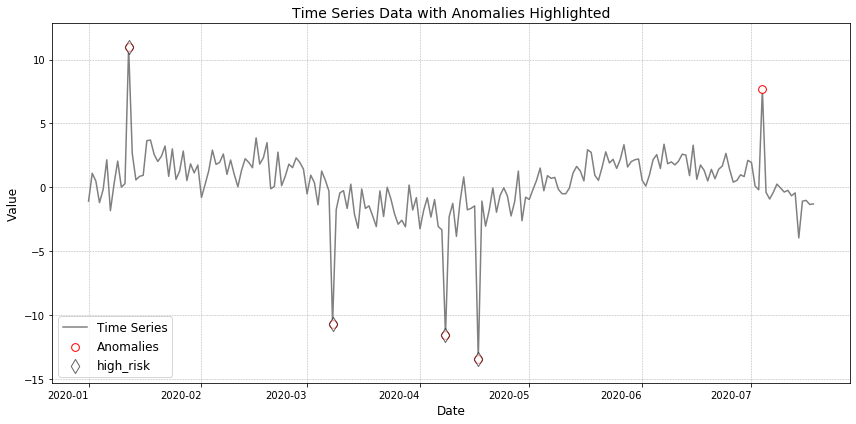

In [4]:
# Visualize the time series data with anomalies highlighted
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['value'], label='Time Series', color='gray')
plt.scatter(anomalies.index, anomalies['value'], color='white', label='Anomalies', zorder=5, s=60, edgecolors='red')
plt.scatter(data.index[data['high_risk']], data['value'][data['high_risk']], color='white', label='high_risk',
            zorder=5, s=100, edgecolors='black', marker='d', alpha=0.6)

plt.title('Time Series Data with Anomalies Highlighted', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

In [5]:
# Anomaly Detection using Isolation Forest

# standardize the value amounts
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[['value']])

#  Apply Isolation Forest for Anomaly Detection
model = IsolationForest(
    n_estimators=100,          # Number of trees in the forest
    contamination=0.03,        # Contamination factor (expected percentage of anomalies)
    max_samples=256,           # Number of samples to train each tree on (use a fraction if dataset is large)
    random_state=123,          # Ensure reproducibility
    max_features=1.0,          # Use all features 
    bootstrap=False,           # Use bootstrapping (False for faster training)
    n_jobs=-1,                 # Use all cores for parallel computation
    warm_start=False           # Option to add data incrementally (can be set True for large datasets)
)

anomalies = model.fit_predict(data_scaled)

# Convert the anomaly labels (-1 for anomaly, 1 for normal)
data['anomaly'] = anomalies
data['anomaly'] = data['anomaly'].map({1: False, -1: True})

display(data.head())

# Analyze the Detected Anomalies
anomalous_values = data[data['anomaly'] == True]
print("\nAnomalous values Detected:")
display(anomalous_values)

,value,true_anomaly,risk_score,high_risk,anomaly
2020-01-01,-1.085631,False,0.099096,False,False
2020-01-02,1.097806,False,0.100207,False,False
2020-01-03,0.483645,False,0.044147,False,False
2020-01-04,-1.205928,False,0.110076,False,False
2020-01-05,-0.179292,False,0.016366,False,False



Anomalous values Detected:


,value,true_anomaly,risk_score,high_risk,anomaly
2020-01-12,10.955374,True,1.000000,True,True
2020-03-08,-10.679776,True,0.974844,True,True
2020-04-08,-11.575725,True,1.056625,True,True
2020-04-17,-13.436432,True,1.226469,True,True
2020-07-04,7.698833,True,0.702745,False,True
2020-07-14,-3.962143,False,0.361662,False,True


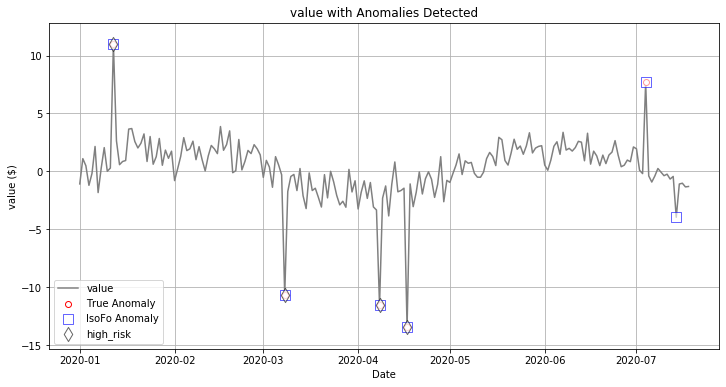

In [6]:
# Visualize the Anomalies in the Data
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['value'], label='value', color='gray')
plt.scatter(data.index[data['true_anomaly']], data['value'][data['true_anomaly']], color='white',
            label='True Anomaly', zorder=5, edgecolors='red')
plt.scatter(data.index[data['anomaly']], data['value'][data['anomaly']], color='white', label='IsoFo Anomaly',
            zorder=5, s=100, edgecolors='blue', marker='s', alpha=0.6)
plt.scatter(data.index[data['high_risk']], data['value'][data['high_risk']], color='white', label='high_risk',
            zorder=5, s=100, edgecolors='black', marker='d', alpha=0.6)

plt.title('value with Anomalies Detected')
plt.xlabel('Date')
plt.ylabel('value ($)')
plt.grid(True)
plt.legend()
plt.show()

Model Evaluation Report:
              precision    recall  f1-score   support

       False       1.00      0.99      1.00       195
        True       0.83      1.00      0.91         5

    accuracy                           0.99       200
   macro avg       0.92      1.00      0.95       200
weighted avg       1.00      0.99      1.00       200



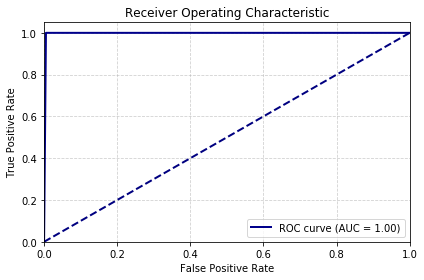

In [7]:
# Evaluate model performance (Precision, Recall, F1-Score)

# Print detailed classification report
print("Model Evaluation Report:")
print(classification_report(data['true_anomaly'], data['anomaly']))

# Plot ROC curve to evaluate model performance in terms of AUC
fpr, tpr, _ = roc_curve(data['true_anomaly'], data['anomaly'])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkblue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [10]:
# Define a risk-based action system
def risk_based_action(risk_score):
    if risk_score > 0.9:
        return "High Risk - Alert"
    elif risk_score > 0.7:
        return "Medium Risk - Review"
    else:
        return "Low Risk - Ignore"

# Apply decision rules
data['risk_action'] = data['risk_score'].apply(risk_based_action)

# Display data with assigned risk actions
data[ (data['risk_action'] == 'High Risk - Alert') | (data['risk_action'] == 'Medium Risk - Review') | data['anomaly']]

,value,true_anomaly,risk_score,high_risk,anomaly,risk_action
2020-01-12,10.955374,True,1.000000,True,True,High Risk - Alert
2020-03-08,-10.679776,True,0.974844,True,True,High Risk - Alert
2020-04-08,-11.575725,True,1.056625,True,True,High Risk - Alert
2020-04-17,-13.436432,True,1.226469,True,True,High Risk - Alert
2020-07-04,7.698833,True,0.702745,False,True,Medium Risk - Review
2020-07-14,-3.962143,False,0.361662,False,True,Low Risk - Ignore
